## Bi-directional LSTM with GloVe, ANN to predict sentiment of topic and LSTM to predict sentiment of text, finally models ensembled to make final prediction

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
import plotly.graph_objects as go
import time
from textblob import TextBlob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [52]:
text_embedding_dimension = 200
key_embedding_dimension = 50


path_to_glove_file = "../../data/embeddings/glove.6B/glove.6B.200d.txt".format(text_embedding_dimension)

embeddings_index_200 = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index_200[word] = coefs

print("Found %s word vectors." % len(embeddings_index_200))

path_to_glove_file = "../../data/embeddings/glove.6B/glove.6B.50d.txt".format(key_embedding_dimension)

embeddings_index_25 = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index_25[word] = coefs

print("Found %s word vectors." % len(embeddings_index_25))

Found 400000 word vectors.
Found 400000 word vectors.


In [53]:
df = pd.read_csv('../../data/processed/clean_reviews_w_topics.csv')
df['labels'] = [1 if label =='positive' else 0 for label in df['sentiment']] 
df.head()

,sentiment,time,text,cleaned_text,label,topic_id,word_1,weight_1,word_2,weight_2,...,weight_6,word_7,weight_7,word_8,weight_8,word_9,weight_9,word_10,weight_10,labels
0,positive,2021-06-18,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...,1,4,dog,0.120393,food,0.049990,...,0.022805,make,0.022782,love,0.021166,chicken,0.021030,feed,0.018323,1
1,positive,2021-07-07,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...,1,4,dog,0.120393,food,0.049990,...,0.022805,make,0.022782,love,0.021166,chicken,0.021030,feed,0.018323,1
2,positive,2021-06-18,"Before I was educated about feline nutrition, ...",educate feline nutrition allow cat become addi...,1,15,cat,0.191703,food,0.075354,...,0.029152,one,0.026079,diet,0.026007,vomit,0.024294,feed,0.023922,1
3,positive,2021-07-07,"My holistic vet recommended this, along with a...",holistic vet recommend along brand try cat pre...,1,15,cat,0.191703,food,0.075354,...,0.029152,one,0.026079,diet,0.026007,vomit,0.024294,feed,0.023922,1
4,positive,2021-01-07,I bought this coffee because its much cheaper ...,buy coffee much cheap ganocafe organic reishi ...,1,0,coffee,0.136692,cup,0.045320,...,0.025706,strong,0.021053,brew,0.020904,good,0.020771,price,0.020030,1


In [54]:
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.split())
df.head()

,sentiment,time,text,cleaned_text,label,topic_id,word_1,weight_1,word_2,weight_2,...,weight_6,word_7,weight_7,word_8,weight_8,word_9,weight_9,word_10,weight_10,labels
0,positive,2021-06-18,This is a very healthy dog food. Good for thei...,"[healthy, dog, food, good, digestion, also, go...",1,4,dog,0.120393,food,0.049990,...,0.022805,make,0.022782,love,0.021166,chicken,0.021030,feed,0.018323,1
1,positive,2021-07-07,I've been very pleased with the Natural Balanc...,"[pleased, natural, balance, dog, food, dog, is...",1,4,dog,0.120393,food,0.049990,...,0.022805,make,0.022782,love,0.021166,chicken,0.021030,feed,0.018323,1
2,positive,2021-06-18,"Before I was educated about feline nutrition, ...","[educate, feline, nutrition, allow, cat, becom...",1,15,cat,0.191703,food,0.075354,...,0.029152,one,0.026079,diet,0.026007,vomit,0.024294,feed,0.023922,1
3,positive,2021-07-07,"My holistic vet recommended this, along with a...","[holistic, vet, recommend, along, brand, try, ...",1,15,cat,0.191703,food,0.075354,...,0.029152,one,0.026079,diet,0.026007,vomit,0.024294,feed,0.023922,1
4,positive,2021-01-07,I bought this coffee because its much cheaper ...,"[buy, coffee, much, cheap, ganocafe, organic, ...",1,0,coffee,0.136692,cup,0.045320,...,0.025706,strong,0.021053,brew,0.020904,good,0.020771,price,0.020030,1


In [55]:
unknown_words = []
total_words = 0

def find_unknown_words(words):
    
    global total_words
    total_words = total_words + len(words)
    
    for word in words:
        if not (word in embeddings_index_200):
            unknown_words.append(word)
    
    return words


df['cleaned_text'].apply(lambda words: find_unknown_words(words))

print( f'{len(unknown_words)/total_words*100:5.2} % of words are unknown' )

  1.1 % of words are unknown


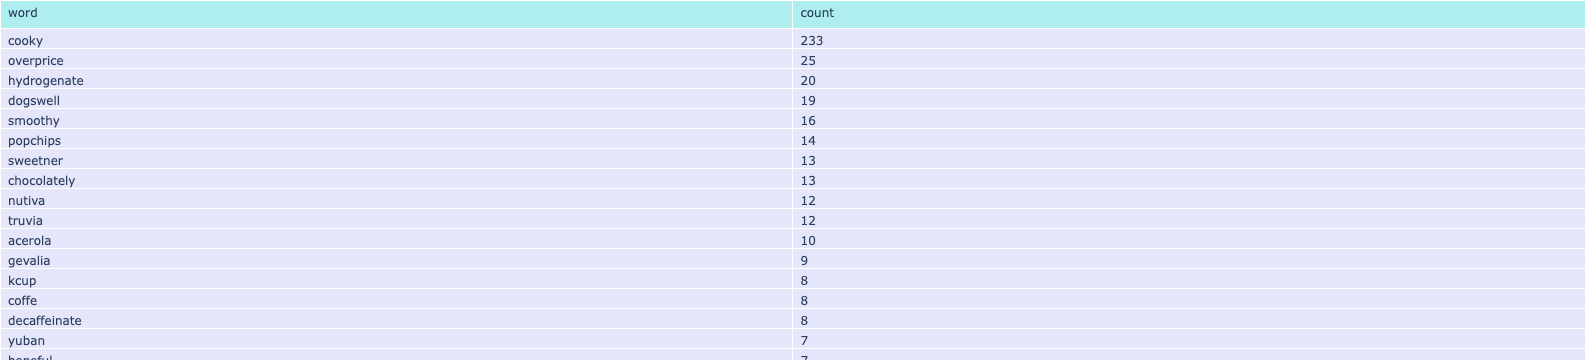

In [56]:
def analyze_unknown_words(unknown_words):
    
    unknown_words = np.array(unknown_words)
    (word, count) = np.unique(unknown_words, return_counts=True)
    
    word_freq = pd.DataFrame({'word': word, 'count': count}).sort_values('count', ascending=False)

    fig = go.Figure(data=[go.Table(
          header=dict(values=list(word_freq.columns),
                    fill_color='paleturquoise',
                    align='left'),
          cells=dict(values=[word_freq['word'], word_freq['count']],
                    fill_color='lavender',
                    align='left'))
          ])
    fig.update_layout(width=300, height=300, margin={'b':0, 'l':0, 'r':0, 't':0, 'pad':0})
    fig.show()
        
analyze_unknown_words(unknown_words)

In [57]:
def text_embed(words):
    
    unknown_indices = []
    mean = np.zeros(text_embedding_dimension)
    
    for i in range(len(words)):
        if words[i] in embeddings_index_200:
            words[i] = embeddings_index_200[ words[i] ]
            mean += words[i]
        else:
            unknown_indices.append(i)
            
    mean /= len(words)-len(unknown_indices)
    
    # unknown words in the text are represented using the mean of the known words
    for i in unknown_indices:
        words[i] = mean
    
    return np.array(words)

df['cleaned_text'] = df['cleaned_text'].apply(lambda words: text_embed(words))

In [58]:
def keyword_embed(keyword, text):
    
    if pd.isna(keyword):
        keyword = np.zeros(50)
    else:
        keyword = keyword.lower()
        keyword = re.sub("[^a-z ]+", ' ', keyword)
        keywords = keyword.split()

        if len(keywords) == 0:
            keyword = np.zeros(key_embedding_dimension)
        else:
            keyword = np.zeros(key_embedding_dimension)
            word_count = 0
            for word in keywords:
                if word in embeddings_index_25:
                    # print(keyword)
                    # print(embeddings_index_25[word])
                    keyword += embeddings_index_25[word]
                    word_count += 1

            if word_count > 0:
                keyword = keyword / word_count
 
    return keyword

df['word_1'] = df.apply(lambda x: keyword_embed(x['word_1'], x['cleaned_text']), axis=1)

In [59]:
cross_validation_ratio = 0.2
# cross_validation_ratio = 0.05

mask = np.random.rand(len(df)) > cross_validation_ratio

train_df = df[mask]

val_df = df[~mask]

In [60]:
x_train_text = train_df['cleaned_text'].values
x_train_key = train_df['word_1'].values

x_val_text = val_df['cleaned_text'].values
x_val_key = val_df['word_1'].values

y_train = train_df['label'].values
y_val = val_df['label'].values

In [61]:
x_train_key = np.array( [i for i in x_train_key] ).reshape(-1, key_embedding_dimension)
x_val_key = np.array( [i for i in x_val_key] ).reshape(-1, key_embedding_dimension)

ANN to predict sentiment of keywords

In [62]:
class ANN_Model(nn.Module):
    def __init__(self):
        super().__init__()                          
        self.fc1 = nn.Linear(key_embedding_dimension, 10)
        self.fc2 = nn.Linear(10, 1)
        self.bn1 = nn.BatchNorm1d(10)
        self.dropout1 = nn.Dropout(p=0.1)

    def forward(self, X):
        X = self.fc1(X)
        X = self.bn1(X)
        X = F.relu(X)
        X = self.dropout1(X)
        X = self.fc2(X)
        X = torch.sigmoid(X)
        return X

In [63]:
ann_model = ANN_Model()

# if cuda0 != None:
#   ann_model.to(cuda0)

criterion_key = nn.BCELoss()
optimizer_key = torch.optim.Adam(ann_model.parameters(), lr=0.01)
# scheduler_key = torch.optim.lr_scheduler.ExponentialLR(optimizer_key, gamma=0.8)

In [64]:
ann_model

ANN_Model(
  (fc1): Linear(in_features=50, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
)

In [65]:
start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(300):  
    
    ann_model.train()

    tweet = torch.FloatTensor(x_train_key)
    label = torch.FloatTensor(y_train)

    # if cuda0 != None:
    #     tweet = tweet.cuda()
    #     label = label.cuda()

    pred = ann_model(tweet)
    pred = pred.reshape(-1)

    loss = criterion_key(pred, label)

    optimizer_key.zero_grad()
    loss.backward()
    optimizer_key.step()

    train_losses.append(loss.item())
    train_accuracies.append( ( (pred>0.5) == (label==1) ).sum().item() / len(x_train_key) )
    
    ann_model.eval()

    with torch.no_grad():

        tweet = torch.FloatTensor(x_val_key)
        label = torch.FloatTensor(y_val)

        # if cuda0 != None:
        #     tweet = tweet.cuda()
        #     label = label.cuda()

        pred = ann_model(tweet)
        pred = pred.reshape(-1)

        loss = criterion_key(pred, label)

    val_losses.append(loss.item())
    val_accuracies.append( ( (pred>0.5) == (label==1) ).sum().item() / len(x_val_key) )
    
    if (epoch+1)%50 == 0:
        print('Epoch {} Summary:'.format(epoch+1))
        print(f'Train Loss: {train_losses[-1]:7.2f}  Train Accuracy: {train_accuracies[-1]*100:6.3f}%')
        print(f'Validation Loss: {val_losses[-1]:7.2f}  Validation Accuracy: {val_accuracies[-1]*100:6.3f}%')
        print('')

    # scheduler_key.step()

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch 50 Summary:
Train Loss:    0.55  Train Accuracy: 74.012%
Validation Loss:    0.55  Validation Accuracy: 74.084%

Epoch 100 Summary:
Train Loss:    0.55  Train Accuracy: 74.012%
Validation Loss:    0.55  Validation Accuracy: 74.084%

Epoch 150 Summary:
Train Loss:    0.55  Train Accuracy: 74.012%
Validation Loss:    0.55  Validation Accuracy: 74.084%

Epoch 200 Summary:
Train Loss:    0.55  Train Accuracy: 74.012%
Validation Loss:    0.55  Validation Accuracy: 74.084%

Epoch 250 Summary:
Train Loss:    0.55  Train Accuracy: 74.012%
Validation Loss:    0.55  Validation Accuracy: 74.084%

Epoch 300 Summary:
Train Loss:    0.55  Train Accuracy: 74.012%
Validation Loss:    0.55  Validation Accuracy: 74.084%


Duration: 2 seconds


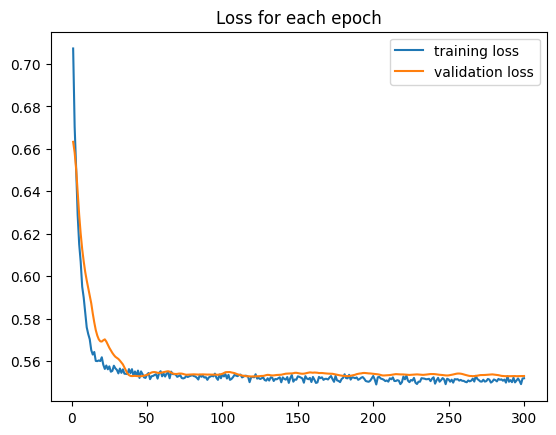

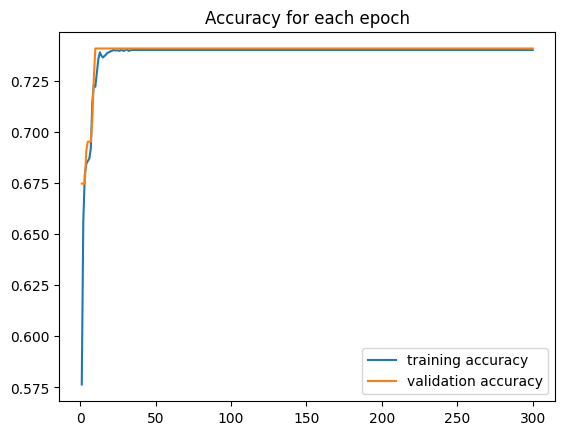

In [66]:
x_axis = [i+1 for i in range(len(train_losses))]

plt.plot(x_axis, train_losses, label='training loss')
plt.plot(x_axis, val_losses, label='validation loss')
plt.title('Loss for each epoch')
plt.legend();
plt.show()

plt.plot(x_axis, train_accuracies, label='training accuracy')
plt.plot(x_axis, val_accuracies, label='validation accuracy')
plt.title('Accuracy for each epoch')
plt.legend();
plt.show()

In [67]:
ann_model.eval()

# predictions for the training set
with torch.no_grad():

    tweet = torch.FloatTensor(x_train_key)

    # if cuda0 != None:
    #     tweet = tweet.cuda()

    pred_train_key = ann_model(tweet)
    pred_train_key = pred_train_key.reshape(-1)
    

# predictions for the cross validation set
with torch.no_grad():

    tweet = torch.FloatTensor(x_val_key)

#     if cuda0 != None:
#         tweet = tweet.cuda()

    pred_val_key = ann_model(tweet)
    pred_val_key = pred_val_key.reshape(-1)

LSTM to predict sentiment of text

In [68]:
class LSTMnetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 50
        self.input_size = text_embedding_dimension
        self.num_layers = 1
        self.bidirectional = True
        self.num_directions = 1
        self.dropout1 = nn.Dropout(p=0.3)

        if self.bidirectional:
            self.num_directions = 2
 
        self.lstm = nn.LSTM( self.input_size, self.hidden_size, self.num_layers, 
                             bidirectional=self.bidirectional )
        
        self.linear = nn.Linear(self.hidden_size*self.num_directions,1)

    def forward(self, tweet):
        
        lstm_out, _ = self.lstm( tweet.view(len(tweet), 1, -1) )

        x = self.dropout1( lstm_out.view(len(tweet),-1) )
        
        output = self.linear(x)
        
        pred = torch.sigmoid( output[-1] )
        
        return pred

In [69]:
lstm_model = LSTMnetwork()

# if cuda0 != None:
#   lstm_model.to(cuda0)

criterion_text = nn.BCELoss()
optimizer_text = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
scheduler_text = torch.optim.lr_scheduler.ExponentialLR(optimizer_text, gamma=0.1)

In [70]:
lstm_model

LSTMnetwork(
  (dropout1): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(200, 50, bidirectional=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [71]:
# ann_model_weight = 0.1
# lstm_model_weight = 1-ann_model_weight

In [72]:
start_time = time.time()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(10):  

    epoch_start_time = time.time()

    print('Epoch : {}'.format(epoch+1))

    trainLoss = 0
    correct = 0

    lstm_model.train()

    for i in range(len(x_train_text)):

        lstm_model.zero_grad()

        tweet = torch.FloatTensor(x_train_text[i])
        label = torch.FloatTensor( np.array([y_train[i]]) )

        # if cuda0 != None:
        #     tweet = tweet.cuda()
        #     label = label.cuda()

        pred = lstm_model(tweet)
        
        loss = criterion_text(pred, label)

        lambdaParam = torch.tensor(0.001)
        l2_reg = torch.tensor(0.)

        # if cuda0 != None:
        #   lambdaParam = lambdaParam.cuda()
        #   l2_reg = l2_reg.cuda() 

        for param in lstm_model.parameters():
          # if cuda0 != None:
          #   l2_reg += torch.norm(param).cuda()
          # else:
            l2_reg += torch.norm(param)

        loss += lambdaParam * l2_reg

        pred = pred.item()
        # *lstm_model_weight + pred_train_key[i].item()*ann_model_weight
        
        if pred > 0.5:
            pred = 1
        else:
            pred = 0

        if pred == int( label.item() ):
            correct += 1

        trainLoss += loss.item()

        optimizer_text.zero_grad()
        loss.backward()
        
        optimizer_text.step()

        if (i+1)%1000 == 0:
            print('Processed {} tweets out of {}'.format(i+1, len(x_train_text)))

    train_losses.append(trainLoss/len(x_train_text))
    train_accuracies.append( correct/len(x_train_text) )

    valLoss = 0
    correct = 0

    lstm_model.eval()

    with torch.no_grad():

        for i in range(len(x_val_text)):

            tweet = torch.FloatTensor(x_val_text[i])
            label = torch.FloatTensor( np.array([y_val[i]]) )

            # if cuda0 != None:
            #     tweet = tweet.cuda()
            #     label = label.cuda()

            pred = lstm_model( tweet )

            loss = criterion_text(pred, label)

            valLoss += loss.item()

            pred = pred.item()
            # *lstm_model_weight + pred_val_key[i].item()*ann_model_weight

            if pred > 0.5:
                pred = 1
            else:
                pred = 0

            if pred == int( label.item() ):
                correct += 1

    val_losses.append(valLoss/len(x_val_text))
    val_accuracies.append( correct/len(x_val_text) )

    print('Epoch Summary:')
    print(f'Train Loss: {train_losses[-1]:7.2f}  Train Accuracy: {train_accuracies[-1]*100:6.3f}%')
    print(f'Validation Loss: {val_losses[-1]:7.2f}  Validation Accuracy: {val_accuracies[-1]*100:6.3f}%')
    print(f'Duration: {time.time() - epoch_start_time:.0f} seconds')
    print('')

    scheduler_text.step()

print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch : 1
Processed 1000 tweets out of 4325
Processed 2000 tweets out of 4325
Processed 3000 tweets out of 4325
Processed 4000 tweets out of 4325
Epoch Summary:
Train Loss:    0.28  Train Accuracy: 92.000%
Validation Loss:    4.72  Validation Accuracy: 25.916%
Duration: 42 seconds

Epoch : 2
Processed 1000 tweets out of 4325
Processed 2000 tweets out of 4325
Processed 3000 tweets out of 4325
Processed 4000 tweets out of 4325
Epoch Summary:
Train Loss:    0.37  Train Accuracy: 87.931%
Validation Loss:    2.64  Validation Accuracy: 27.435%
Duration: 38 seconds

Epoch : 3
Processed 1000 tweets out of 4325
Processed 2000 tweets out of 4325
Processed 3000 tweets out of 4325
Processed 4000 tweets out of 4325
Epoch Summary:
Train Loss:    0.94  Train Accuracy: 62.867%
Validation Loss:    0.68  Validation Accuracy: 62.556%
Duration: 39 seconds

Epoch : 4
Processed 1000 tweets out of 4325
Processed 2000 tweets out of 4325
Processed 3000 tweets out of 4325
Processed 4000 tweets out of 4325
Epoch

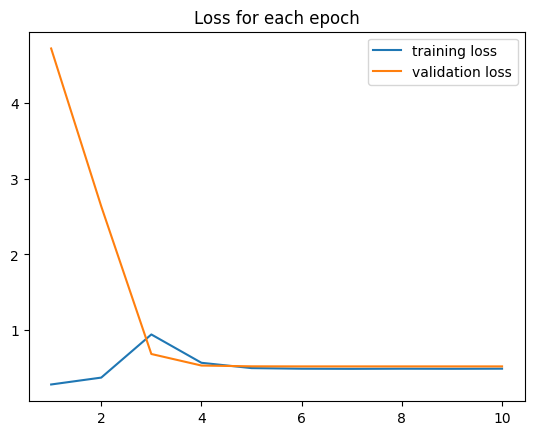

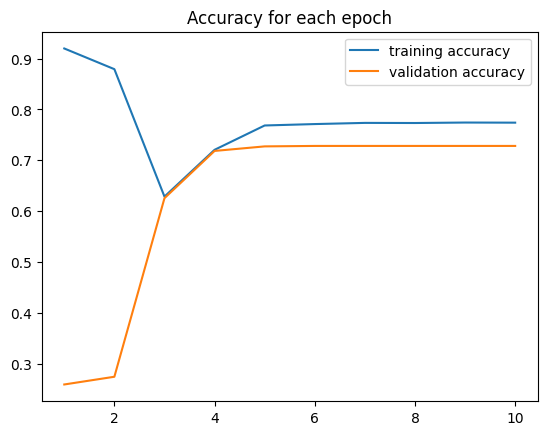

In [73]:
x_axis = [i+1 for i in range(len(train_losses))]

plt.plot(x_axis, train_losses, label='training loss')
plt.plot(x_axis, val_losses, label='validation loss')
plt.title('Loss for each epoch')
plt.legend();
plt.show()

plt.plot(x_axis, train_accuracies, label='training accuracy')
plt.plot(x_axis, val_accuracies, label='validation accuracy')
plt.title('Accuracy for each epoch')
plt.legend();
plt.show()

## Simple LSTM with GloVe Embeddings 

In [24]:
#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
import jovian
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

<IPython.core.display.Javascript object>

In [25]:
df = pd.read_csv('../../data/processed/cleaned_reviews.csv')
df['labels'] = [1 if label =='positive' else 0 for label in df['Sentiment']] 
df.head()

,Unnamed: 0,Sentiment,Time,Text,review_length,clean_reviews,clean_review_length,labels
0,0,positive,2021-06-18,This is a very healthy dog food. Good for thei...,137,healthy dog food good digestion also good smal...,94,1
1,1,positive,2021-07-07,I've been very pleased with the Natural Balanc...,350,pleased natural balance dog food dogs issues d...,218,1
2,2,positive,2021-06-18,"Before I was educated about feline nutrition, ...",733,educated feline nutrition allowed cats become ...,508,1
3,3,positive,2021-07-07,"My holistic vet recommended this, along with a...",493,holistic vet recommended along brands tried ca...,276,1
4,4,positive,2021-01-07,I bought this coffee because its much cheaper ...,413,bought coffee much cheaper ganocafe organic re...,218,1


In [26]:
np.mean(df['clean_review_length'])

217.28416605437178

In [27]:
#tokenization
nlp = spacy.load("en_core_web_sm")
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in nlp.tokenizer(nopunct)]

In [28]:
#count number of occurences of each word
counts = Counter()
for index, row in df.iterrows():
    counts.update(tokenize(row['clean_reviews']))

In [29]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 14120
num_words after: 7097


In [30]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [31]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [32]:
df['encoded'] = df['clean_reviews'].apply(lambda x: np.array(encode_sentence(x,vocab2index), dtype = 'object'))
df.head()

,Unnamed: 0,Sentiment,Time,Text,review_length,clean_reviews,clean_review_length,labels,encoded
0,0,positive,2021-06-18,This is a very healthy dog food. Good for thei...,137,healthy dog food good digestion also good smal...,94,1,"[[2, 3, 4, 5, 6, 7, 5, 8, 9, 3, 10, 11, 12, 13..."
1,1,positive,2021-07-07,I've been very pleased with the Natural Balanc...,350,pleased natural balance dog food dogs issues d...,218,1,"[[15, 16, 17, 3, 4, 18, 19, 3, 20, 21, 22, 23,..."
2,2,positive,2021-06-18,"Before I was educated about feline nutrition, ...",733,educated feline nutrition allowed cats become ...,508,1,"[[36, 37, 38, 39, 40, 41, 42, 43, 44, 4, 45, 4..."
3,3,positive,2021-07-07,"My holistic vet recommended this, along with a...",493,holistic vet recommended along brands tried ca...,276,1,"[[72, 82, 83, 84, 85, 86, 40, 87, 88, 89, 90, ..."
4,4,positive,2021-01-07,I bought this coffee because its much cheaper ...,413,bought coffee much cheaper ganocafe organic re...,218,1,"[[114, 115, 116, 117, 118, 119, 1, 120, 121, 2..."


In [33]:
X = list(df['encoded'])
y = list(df['labels'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state = 4263)

In [34]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [35]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [36]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [37]:
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [41]:
def load_glove_vectors(glove_file="../../data/embeddings/glove.6B/glove.6B.50d.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [42]:
def get_emb_matrix(pretrained, word_counts, emb_size = 50):
    """ Creates embedding matrix from word vectors"""
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx

In [43]:
word_vecs = load_glove_vectors()
pretrained_weights, vocab, vocab2index = get_emb_matrix(word_vecs, counts)

In [44]:
class LSTM_glove_vecs(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [45]:
model = LSTM_glove_vecs(vocab_size, 50, 50, pretrained_weights)

In [46]:
train_model(model, epochs=30, lr=0.1)

train loss 0.583, val loss 0.578, val accuracy 0.735, and val rmse 0.515
train loss 0.868, val loss 0.687, val accuracy 0.738, and val rmse 0.512
train loss 0.576, val loss 0.608, val accuracy 0.738, and val rmse 0.512
train loss 0.569, val loss 0.593, val accuracy 0.736, and val rmse 0.513
train loss 0.573, val loss 0.595, val accuracy 0.738, and val rmse 0.512
train loss 0.574, val loss 0.589, val accuracy 0.723, and val rmse 0.527
